In [1]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.model_selection import cross_validate
from sklearn.metrics import *

from tools import helpers as h

from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt

### Read in Louvain Subclusters

In [2]:
louv = pd.read_csv('../data/cluster/louvain_clusters.txt', index_col=0, sep='\t')
louv.columns = ['cluster_super']
louv = louv.merge(pd.read_csv('../data/cluster/louvain_small_clusters.txt', index_col=0, sep='\t'), left_index=True, right_index=True)
louv.columns = ['cluster_super', 'cluster_sub']
louv.head()

,cluster_super,cluster_sub
names,,
MST1R,3,11
YES1,3,11
TYRO3,3,11
FGR,3,11
SRC,3,11


### Get the HGNC Mapper

In [3]:
hgnc_mapper = h.fetch_hgnc_mapper()

In [4]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

### Klaeger Science Data

In [5]:
# initial target list -- not for linear programming
klaeger = pd.read_excel('../data/ref/Klaeger_Science_2017 Supplementary Table 2 Target Lists.xlsx', sheet_name='Kinobeads')

# a number of drugs have very similar targets listed in the same row
# we parse to separate these out 
klaeger = splitDataFrameList(klaeger, 'Gene Name', ';')
# filter to only hgnc keys
klaeger = klaeger[klaeger['Gene Name'].isin(hgnc_mapper.keys())]

# convert to hgnc
klaeger['Gene Name'] = klaeger['Gene Name'].apply(lambda x: hgnc_mapper[x])

# filter to our kinases
klaeger = klaeger[klaeger['Gene Name'].isin(set(louv.index))]

# lower drug names
klaeger['Drug'] = [x.lower().replace('-', '') for x in klaeger.Drug]

klaeger.head()

,Apparent Kd,BIC,Beads,Bottom,Correction Factor,DMSO Intensity,Drug,EC50,EC50 Standard Error,Gene Name,...,Relative Intensity 1000 nM,Relative Intensity 3 nM,Relative Intensity 30 nM,Relative Intensity 300 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM,Relative Intensity DMSO,Slope,Target Classification,Top
0,101.828368,-20.503519,Kinobeads,0.009092,0.673073,136300000,abemaciclib,151.288760,45.696999,AAK1,...,0.181984,0.905556,0.738292,0.323354,0.063421,0.057103,1,0.773714,High confidence,0.957905
1,39.805937,-12.606135,Kinobeads,-0.001200,0.622595,10460000,abemaciclib,63.935536,68.832970,ADCK1,...,0.000000,1.045974,1.141565,0.000000,0.000000,0.000000,1,12.051439,High confidence,1.014355
2,56031.642989,-15.330485,Kinobeads,-1.003278,0.660952,72050000,abemaciclib,84774.108960,217756.243215,BMP2K,...,0.885498,1.101696,1.087891,0.863230,0.862572,0.313434,1,0.603088,High confidence,1.034558
3,19.447883,-22.486948,Kinobeads,0.018690,0.203913,888660000,abemaciclib,95.373379,12.131433,CAMK2D,...,0.021331,0.894551,0.900583,0.178266,0.004220,0.017424,1,1.774882,High confidence,0.972850
4,17.889794,1.734623,Kinobeads,0.043265,0.217204,266400000,abemaciclib,82.363844,NaN,CAMK2G,...,0.013431,1.125435,1.236451,0.139777,0.005382,0.017473,1,6.255996,High confidence,1.232332


In [6]:
len(set(klaeger.Drug))

220

In [7]:
len(set(klaeger['Gene Name']))

247

In [8]:
raw_conc_data = klaeger[['Drug', 'Gene Name'] + [x for x in klaeger.columns if 'Relative Intensity' in x and 'DMSO' not in x]]
raw_conc_data.head()

,Drug,Gene Name,Relative Intensity 10 nM,Relative Intensity 100 nM,Relative Intensity 1000 nM,Relative Intensity 3 nM,Relative Intensity 30 nM,Relative Intensity 300 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM
0,abemaciclib,AAK1,0.791054,0.639565,0.181984,0.905556,0.738292,0.323354,0.063421,0.057103
1,abemaciclib,ADCK1,0.869866,0.000000,0.000000,1.045974,1.141565,0.000000,0.000000,0.000000
2,abemaciclib,BMP2K,1.012297,0.973740,0.885498,1.101696,1.087891,0.863230,0.862572,0.313434
3,abemaciclib,CAMK2D,0.984481,0.440384,0.021331,0.894551,0.900583,0.178266,0.004220,0.017424
4,abemaciclib,CAMK2G,1.565245,0.315507,0.013431,1.125435,1.236451,0.139777,0.005382,0.017473


In [9]:
from numba import jit

#@jit()
def gr(conc, GRinf, GR50, GR_Hill_Coeff):
    return GRinf + np.divide(1- GRinf, 1 + np.power(np.divide(conc,GR50+1.e-20), GR_Hill_Coeff)+1.e-20)


def extract_metrics(df, molecule):
    # look for the molecule in the dataframe and extract the relevant items
    return df[df['molecule']==molecule]

### Examine Molecules

In [10]:
agg = pd.read_csv('../data/modelInputs/input_grMetrics.tsv', sep='\t', header=0, index_col=None)

# filter to high r2 values
agg = agg[agg['GR_r2'] > .6]
agg.head()

,molecule,cellline,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50
0,seliciclib,bt20,1.898774,0.194160,-1.00000,1.17820,0.17548,0.97227,0.0,0.0,1.0
1,a443654,bt20,0.051675,-0.492210,-0.63357,0.55758,1.00120,0.98743,0.0,0.0,1.0
3,at7519,bt20,0.186015,-0.401780,-0.40563,1.32240,0.86351,0.99936,0.0,0.0,1.0
4,azd5438,bt20,0.219866,-0.354640,-0.44610,0.79155,0.74810,0.99091,0.0,0.0,1.0
5,azd6482,bt20,0.827110,-0.081485,-0.54825,0.76277,0.42682,0.99881,0.0,0.0,1.0


In [11]:
# filter out nans
agg = agg[agg['GR50'] > 0]

### Begin Merging

In [12]:
display(len(set(agg.molecule)& set(klaeger.Drug)))
display(len(set(agg.molecule) & set(raw_conc_data.Drug)))

82

82

In [13]:
common_drugs = set(agg.molecule) & set(raw_conc_data.Drug)

In [14]:
agg = agg[agg.molecule.isin(common_drugs)]
conc_data = raw_conc_data[raw_conc_data.Drug.isin(common_drugs)]

conc_data.head()

,Drug,Gene Name,Relative Intensity 10 nM,Relative Intensity 100 nM,Relative Intensity 1000 nM,Relative Intensity 3 nM,Relative Intensity 30 nM,Relative Intensity 300 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM
118,afatinib,ADK,1.486669,1.114982,1.106729,1.101254,1.077845,1.371766,0.704253,0.000000
119,afatinib,EGFR,0.000000,0.000000,0.000000,0.501030,0.000000,0.000000,0.000000,0.000000
120,afatinib,GAK,1.006153,1.015382,0.931173,1.105101,1.025470,1.002719,0.625327,0.203584
122,afatinib,MAPK11,1.081225,1.440432,0.860905,0.929032,1.307298,1.221845,0.741909,0.000000
123,afatinib,MAPK14,1.151929,1.065271,0.814896,1.098158,1.147222,0.968552,0.503224,0.171431


In [15]:
conc_data.shape

(1771, 10)

In [16]:
partial_obs = conc_data.melt(id_vars=['Drug', 'Gene Name'], value_name='Intensity')
partial_obs.head()

,Drug,Gene Name,variable,Intensity
0,afatinib,ADK,Relative Intensity 10 nM,1.486669
1,afatinib,EGFR,Relative Intensity 10 nM,0.000000
2,afatinib,GAK,Relative Intensity 10 nM,1.006153
3,afatinib,MAPK11,Relative Intensity 10 nM,1.081225
4,afatinib,MAPK14,Relative Intensity 10 nM,1.151929


In [17]:
remaining_drugs = list(partial_obs.Drug.unique())
remaining_genes = list(partial_obs['Gene Name'].unique())
intensities_unique = list(partial_obs['variable'].unique())

complete_combos = list(it.product(remaining_drugs, remaining_genes, intensities_unique))
print(len(complete_combos))

152848


In [18]:
complete_obs = pd.DataFrame(complete_combos)
complete_obs[4] = 1
complete_obs.columns=['Drug','Gene Name','Concentration','Intensity']
complete_obs.sort_values(by=['Concentration', 'Drug'], inplace=True)
complete_obs.head(10)

,Drug,Gene Name,Concentration,Intensity
0,afatinib,ADK,Relative Intensity 10 nM,1
8,afatinib,EGFR,Relative Intensity 10 nM,1
16,afatinib,GAK,Relative Intensity 10 nM,1
24,afatinib,MAPK11,Relative Intensity 10 nM,1
32,afatinib,MAPK14,Relative Intensity 10 nM,1
40,afatinib,MAPK9,Relative Intensity 10 nM,1
48,afatinib,MAPKAPK2,Relative Intensity 10 nM,1
56,afatinib,MET,Relative Intensity 10 nM,1
64,afatinib,MYLK,Relative Intensity 10 nM,1
72,afatinib,PHKG2,Relative Intensity 10 nM,1


In [19]:
# fill the observations with known data
# we use a multiindex to slice quickly
complete_obs = complete_obs.groupby(['Drug', 'Gene Name', 'Concentration'])['Intensity'].sum()
partial_obs = partial_obs.groupby(['Drug', 'Gene Name', 'variable'])['Intensity'].sum()

In [20]:
for observation in partial_obs.index:
    complete_obs.loc[observation] = partial_obs[observation]
    
complete_obs = complete_obs.reset_index()
partial_obs = partial_obs.reset_index()

In [21]:
# print the 10 smallest values of intensity to show a good epsilon
list(sorted(complete_obs['Intensity'][complete_obs['Intensity']>0]))[:20]

# extract min
min_observed = min(complete_obs['Intensity'][complete_obs['Intensity']>0])

### Here we translate 0 intensities to a very small intensity

In [22]:
# min_cutter assumes machine precision half of smallest
min_cutter = 2
complete_obs['Intensity'][complete_obs['Intensity'] == 0] = min_observed/min_cutter

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# log2 transform the data
complete_obs['Intensity'] = np.log2(complete_obs['Intensity'].values)
complete_obs.head()

,Drug,Gene Name,Concentration,Intensity
0,afatinib,AAK1,Relative Intensity 10 nM,0.0
1,afatinib,AAK1,Relative Intensity 100 nM,0.0
2,afatinib,AAK1,Relative Intensity 1000 nM,0.0
3,afatinib,AAK1,Relative Intensity 3 nM,0.0
4,afatinib,AAK1,Relative Intensity 30 nM,0.0


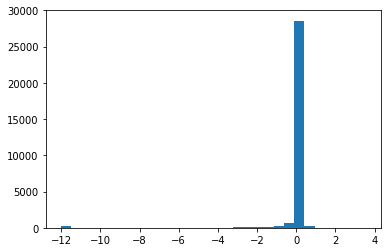

In [24]:
plt.hist(complete_obs.sample(frac=.2)['Intensity'], bins=30)
plt.show()

In [25]:
# first, convert concentration to micromolar (numeric)
complete_obs['Concentration'] = complete_obs['Concentration'].apply(lambda x: float(x.split(' ')[2]))/1000
complete_obs.head()

,Drug,Gene Name,Concentration,Intensity
0,afatinib,AAK1,0.010,0.0
1,afatinib,AAK1,0.100,0.0
2,afatinib,AAK1,1.000,0.0
3,afatinib,AAK1,0.003,0.0
4,afatinib,AAK1,0.030,0.0


### Calculate the growth for each drug x concentration

In [26]:
from time import time
s = time()
interpolated_data = {}
concentrations = list(complete_obs.Concentration.unique())
drugs_pres = complete_obs.Drug.unique()

count = 0
# loop through the observations and create new data
for d in drugs_pres:
    # select observed data
    gr_data_to_interpolate_with = extract_metrics(agg, d)
    
    for i, gr_row in gr_data_to_interpolate_with.iterrows():
        local_gr50, local_grinf, local_grhill, local_cellline = list(gr_row[['GR50', 'GRinf', 'GR_Hill_Coeff', 'cellline']].values)
        
        for c in concentrations:
            interpolated_data[(d, local_cellline, c)] = gr(c, local_grinf, local_gr50, local_grhill)
        
    if count % 10 == 0: 
        print('Done with combo '  + str(count) + '/' + str(len(drugs_pres)))
    count +=1
print(time()-s)

Done with combo 0/82
Done with combo 10/82
Done with combo 20/82
Done with combo 30/82
Done with combo 40/82
Done with combo 50/82
Done with combo 60/82
Done with combo 70/82
Done with combo 80/82
7.500202178955078


In [27]:
interpolated_df = pd.Series(interpolated_data)
interpolated_df.head()

afatinib  hs578t  0.010    0.999997
                  0.100    0.998848
                  1.000    0.674671
                  0.003    1.000000
                  0.030    0.999945
dtype: float64

In [28]:
interpolated_df = pd.DataFrame(interpolated_df)
interpolated_df.head()


0
afatinib hs578t 0.010  0.999997
                0.100  0.998848
                1.000  0.674671
                0.003  1.000000
                0.030  0.999945

In [29]:
interpolated_df = interpolated_df.reset_index()
interpolated_df.columns = ['Drug', 'Cellline', 'Concentration', 'Growth']

In [30]:
interpolated_df['idx'] = interpolated_df['Drug'] + interpolated_df['Concentration'].apply(str)
complete_obs['idx'] = complete_obs['Drug'] + complete_obs['Concentration'].apply(str)

In [31]:
df = interpolated_df.merge(complete_obs, how='left', on='idx')

df = df[['Drug_x', 'Gene Name', 'Cellline', 'Concentration_x', 'Intensity', 'Growth']]
df.columns = ['Drug', 'Gene', 'Cellline', 'Concentration', 'Intensity', 'Growth']
df.head()

,Drug,Gene,Cellline,Concentration,Intensity,Growth
0,afatinib,AAK1,hs578t,0.01,0.0,0.999997
1,afatinib,ABL1,hs578t,0.01,0.0,0.999997
2,afatinib,ABL2,hs578t,0.01,0.0,0.999997
3,afatinib,ACVR1,hs578t,0.01,0.0,0.999997
4,afatinib,ACVR1B,hs578t,0.01,0.0,0.999997


In [32]:
t = df.pivot_table(index=['Drug', 'Cellline', 'Growth', 'Concentration'], columns='Gene')

In [33]:
gene_cols = t.head().reset_index().columns.get_level_values(1).tolist()
gene_cols[:4] = ['Drug', 'Cellline', 'Growth', 'Concentration']

In [34]:
t = t.reset_index()
t.columns = gene_cols

In [35]:
t.shape

(62368, 237)

In [36]:
# standardize the columns
kin_standard_dev = t.std(axis=0)[2:]
t[t.columns[4:]] /= kin_standard_dev

In [37]:
#kin_standard_dev.to_csv('../data/kinase_standard_deviations.csv')

In [38]:
#t.to_csv('../data/target_concentration_data.csv', index=False)

In [39]:
from sklearn.model_selection import train_test_split as tts
#t.to_csv('../data/target_concentration_data.csv', index=False)
t_train, t_test = tts(t, test_size=0.2, random_state=1920)
t_test, t_dev = tts(t_test, test_size=0.5, random_state=1920)

In [40]:
'''t_train.to_csv('../data/modelInputs/standardizedGrowth/train.csv')
t_dev.to_csv('../data/modelInputs/standardizedGrowth/dev.csv')
t_test.to_csv('../data/modelInputs/standardizedGrowth/test.csv')'''

"t_train.to_csv('../data/modelInputs/standardizedGrowth/train.csv')\nt_dev.to_csv('../data/modelInputs/standardizedGrowth/dev.csv')\nt_test.to_csv('../data/modelInputs/standardizedGrowth/test.csv')"

In [41]:
t.head()

,Drug,Cellline,Growth,Concentration,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,...,TGFBR2,TNIK,TNK1,TNK2,TP53RK,TTK,TYK2,ULK1,WEE1,YES1
0,afatinib,184a1,-0.898065,30.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,afatinib,184a1,-0.759458,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,afatinib,184a1,-0.648105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,afatinib,184a1,-0.483650,0.3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,afatinib,184a1,-0.295726,0.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
from sklearn.preprocessing import LabelEncoder
c = LabelEncoder().fit_transform(t.Drug)
drug_ids = dict(zip(c,t.Drug.tolist()))

umap_X = t.groupby(['Drug', 'Concentration']).agg(np.mean).drop('Growth', axis=1).reset_index()
hue = umap_X['Drug']
umap_X = umap_X[umap_X.columns[2:]]                
print(umap_X.shape)
umap_X.head()

(656, 233)


,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ADCK1,ADK,AKT1,AKT2,...,TGFBR2,TNIK,TNK1,TNK2,TP53RK,TTK,TYK2,ULK1,WEE1,YES1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082154,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.337764,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063852,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092706,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269247,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
from umap import UMAP

In [46]:
import seaborn as sns

In [47]:
u_drug = UMAP(metric='cosine', n_neighbors=15)

u_coords = u_drug.fit_transform(umap_X)

In [48]:
plot_text = pd.DataFrame(u_coords)
plot_text['Drug'] = hue
plot_text.head()

,0,1,Drug
0,-2.121398,8.473199,afatinib
1,-2.593452,7.814502,afatinib
2,-2.140419,8.347254,afatinib
3,-2.560608,7.850068,afatinib
4,-2.551072,7.878527,afatinib


In [49]:
from scipy.spatial.distance import cdist
plot_text = plot_text.groupby('Drug').agg(np.mean)

# offset and separation
plot_text[0] = plot_text[0] + .01


plot_text.head()

,0,1
Drug,,
afatinib,-2.483104,7.902869
alisertib,0.981710,1.465196
alvocidib,-3.952080,-1.510953
at7519,-4.070719,-2.827896
axitinib,-0.189732,2.498885


In [50]:
to_fix = np.logical_and(cdist(plot_text.values, plot_text.values) < 1, cdist(np.expand_dims(plot_text[1].values, 1), np.expand_dims(plot_text[1].values,1)) < .2) * 1.
to_fix[np.diag_indices_from(to_fix)] = 0

print(np.sum(to_fix))

68.0


In [51]:
for x,y in zip(*np.where(to_fix)):
    if x < y:
        pass
    else:
        x_y_coord = plot_text.iloc[x, 1]
        y_y_coord = plot_text.iloc[y, 1]
        
        if x_y_coord > y_y_coord:
            plot_text.iloc[x, 1] = x_y_coord + .01
            plot_text.iloc[y, 1] = y_y_coord - .01
        else:
            plot_text.iloc[y, 1] = y_y_coord + .01
            plot_text.iloc[y, 1] = x_y_coord - .01
      

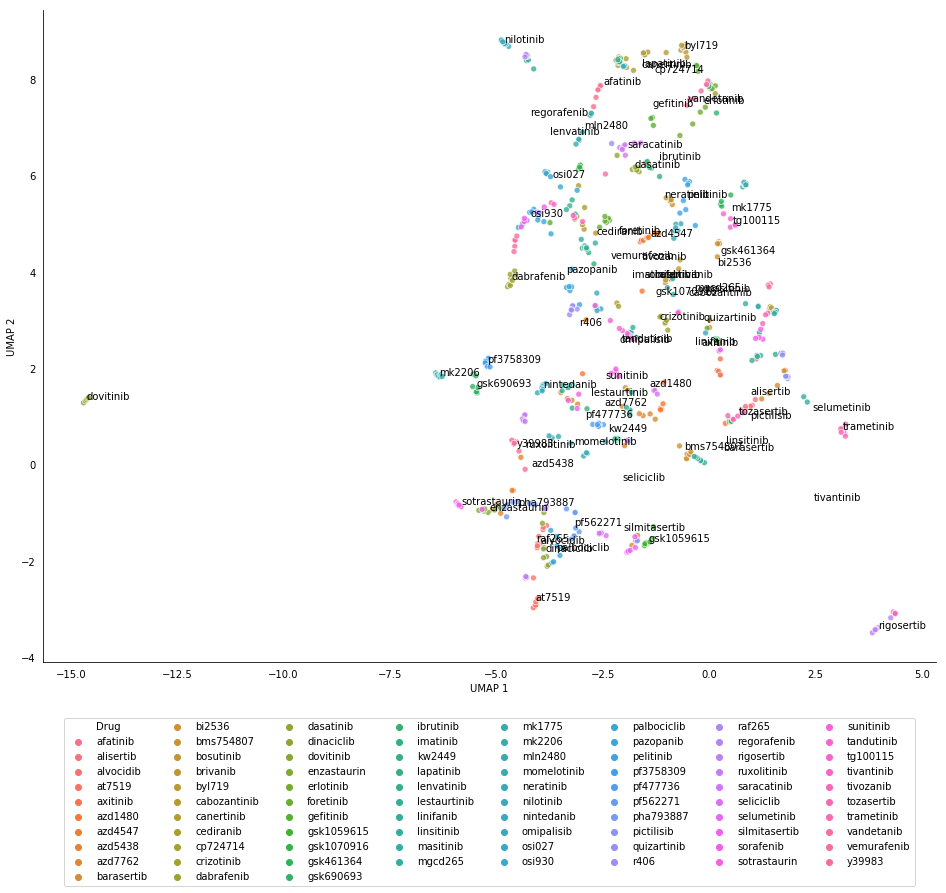

In [52]:
fig, ax = plt.subplots(figsize=(16,12))\

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=u_coords[:, 0].tolist(), y=u_coords[:, 1].tolist(), hue=hue, ax=ax, cmap='viridis', alpha=.8)

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

for i, row in plot_text.iterrows():
    plt.annotate(row.name, (row[0], row[1]))
    
plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

In [53]:
u_drug = UMAP(n_neighbors=15)

u_coords = u_drug.fit_transform(umap_X)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [54]:
plot_text = pd.DataFrame(u_coords)
plot_text['Drug'] = hue
plot_text.head()

,0,1,Drug
0,1.921270,-0.965998,afatinib
1,-0.831940,-2.408012,afatinib
2,-0.716063,-2.620012,afatinib
3,-0.793883,-2.386446,afatinib
4,-0.740883,-2.477700,afatinib


In [55]:
from scipy.spatial.distance import cdist
plot_text = plot_text.groupby('Drug').agg(np.mean)

# offset and separation
plot_text[0] = plot_text[0] + .01


plot_text.head()

,0,1
Drug,,
afatinib,-0.405292,-2.235706
alisertib,4.509804,0.768631
alvocidib,3.008674,-3.207475
at7519,3.657332,-3.868029
axitinib,3.210803,-0.134884


In [56]:
to_fix = np.logical_and(cdist(plot_text.values, plot_text.values) < 1, cdist(np.expand_dims(plot_text[1].values, 1), np.expand_dims(plot_text[1].values,1)) < .2) * 1.
to_fix[np.diag_indices_from(to_fix)] = 0

print(np.sum(to_fix))

196.0


In [57]:
for x,y in zip(*np.where(to_fix)):
    if x < y:
        pass
    else:
        x_y_coord = plot_text.iloc[x, 1]
        y_y_coord = plot_text.iloc[y, 1]
        
        if x_y_coord > y_y_coord:
            plot_text.iloc[x, 1] = x_y_coord + .01
            plot_text.iloc[y, 1] = y_y_coord - .01
        else:
            plot_text.iloc[y, 1] = y_y_coord + .01
            plot_text.iloc[y, 1] = x_y_coord - .01
      

In [58]:
lmnop = t.groupby(['Drug', 'Concentration']).agg(np.mean).reset_index()
lmnop.head()

,Drug,Concentration,Growth,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ADCK1,...,TGFBR2,TNIK,TNK1,TNK2,TP53RK,TTK,TYK2,ULK1,WEE1,YES1
0,afatinib,0.003,0.894134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,afatinib,0.010,0.833127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,afatinib,0.030,0.761255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,afatinib,0.100,0.656311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,afatinib,0.300,0.504731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


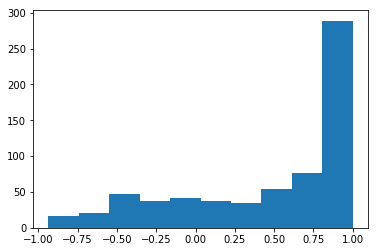

In [59]:
plt.hist(lmnop.Growth)
plt.show()

In [60]:
from importlib import reload

In [61]:
sns = reload(sns)

In [62]:
out_save = lmnop.iloc[:, :3]

In [63]:
out_save['UMAP_x'] = u_coords[:, 0]
out_save['UMAP_y'] = u_coords[:, 1]

In [64]:
out_save.columns = ['Drug', 'Concentration', 'Average Growth', 'UMAP_x', 'UMAP_y']

In [65]:
#out_save.to_csv('drugKinomeVectorEmbeddings.csv')
#out_save = pd.read_csv('drugKinomeVectorEmbeddings.csv', index_col=0)

In [66]:
out_save.head()

,Drug,Concentration,Average Growth,UMAP_x,UMAP_y
0,afatinib,0.003,0.894134,1.921270,-0.965998
1,afatinib,0.010,0.833127,-0.831940,-2.408012
2,afatinib,0.030,0.761255,-0.716063,-2.620012
3,afatinib,0.100,0.656311,-0.793883,-2.386446
4,afatinib,0.300,0.504731,-0.740883,-2.477700


In [67]:
u_coords = out_save[['UMAP_x', 'UMAP_y']].values

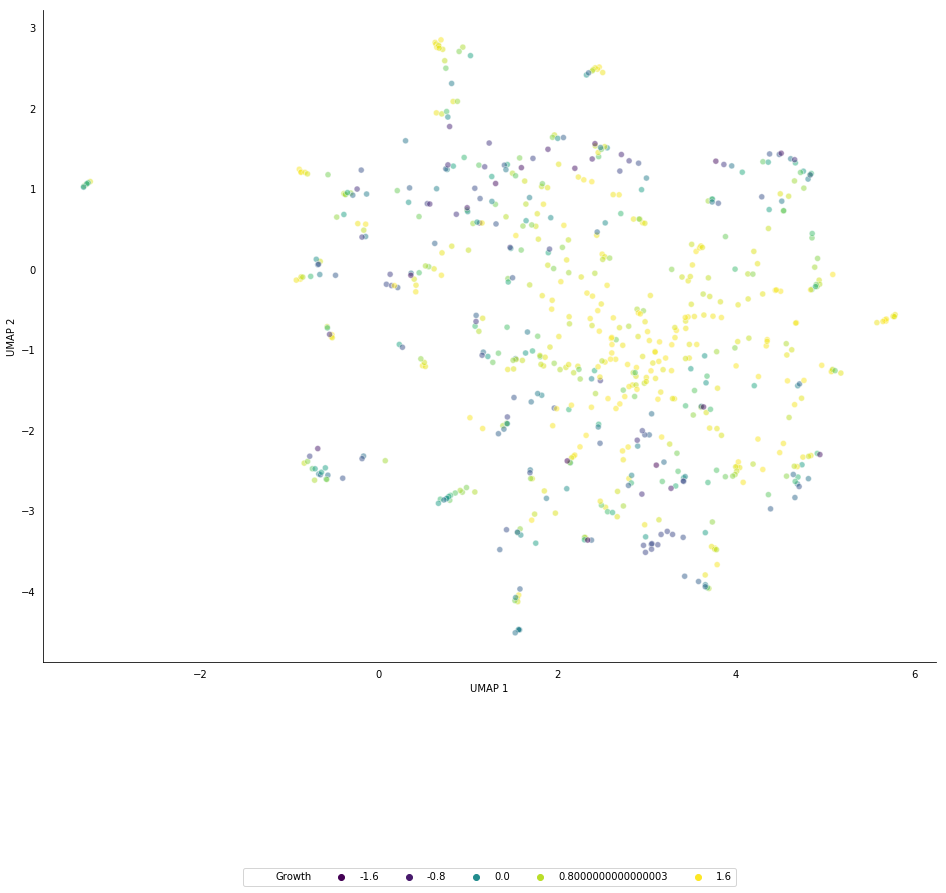

In [68]:
fig, ax = plt.subplots(figsize=(16,12))

#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=u_coords[:, 0].tolist(), y=u_coords[:, 1].tolist(), hue=lmnop.Growth, ax=ax, palette='viridis', vmax=1, vmin=-1, alpha=.5)

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

#for i, row in plot_text.iterrows():
#    plt.annotate(row.name, (row[0], row[1]))
    
plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

In [69]:
from sklearn.neighbors import RadiusNeighborsRegressor

neighbors = RadiusNeighborsRegressor(weights='distance', n_jobs=2)
neighbors.fit(u_coords, lmnop.Growth.values)

RadiusNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=2, p=2, radius=1.0,
             weights='distance')

In [70]:
from sklearn.neighbors import KernelDensity

epanechnikov_density = KernelDensity(kernel = 'epanechnikov')
gaussian_density = KernelDensity(kernel = 'gaussian')

epanechnikov_density.fit(u_coords)
gaussian_density.fit(u_coords)

sample = gaussian_density.sample(n_samples=100000, random_state=1920)
sample_likelihoods = np.exp(epanechnikov_density.score_samples(sample))
keep_probability = np.random.uniform(size=100000)

final_sample = sample[sample_likelihoods > keep_probability, :]

remaining = final_sample.shape[0]
print(remaining, 'samples from epanechnikov kernel kept.', str(remaining/100000.*100)+'% efficiency')

2384 samples from epanechnikov kernel kept. 2.384% efficiency


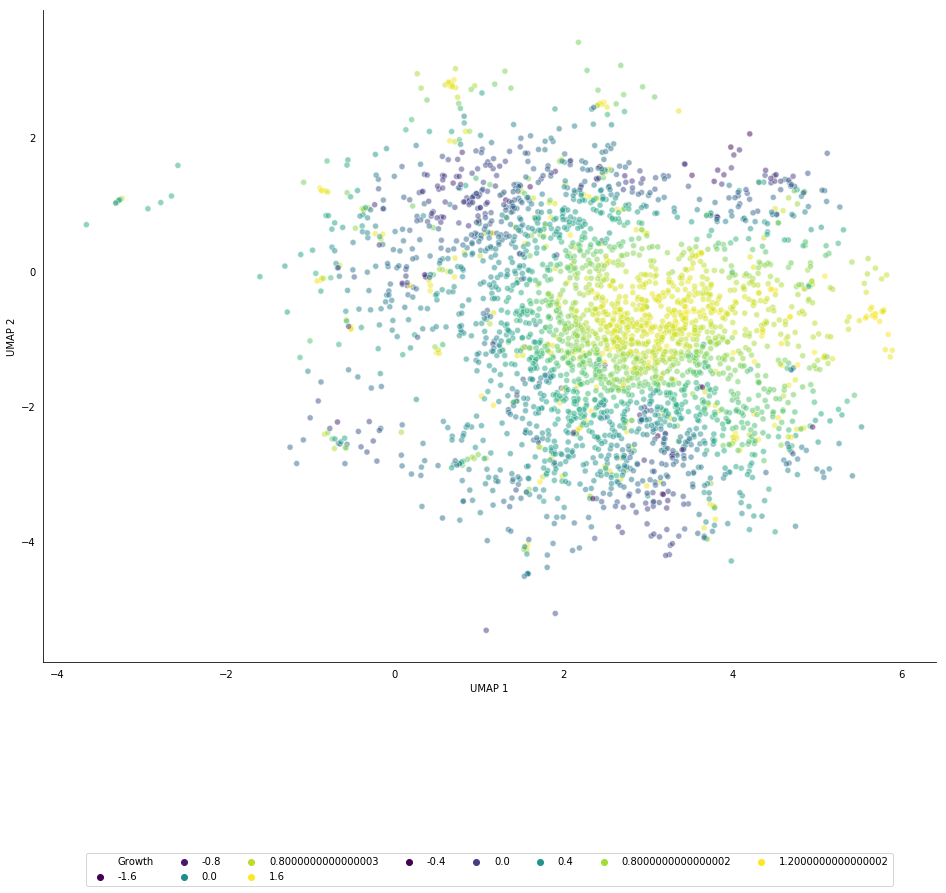

In [71]:
fig, ax = plt.subplots(figsize=(16,12))

#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=u_coords[:, 0].tolist(), y=u_coords[:, 1].tolist(), hue=lmnop.Growth, ax=ax, palette='viridis', vmax=1, vmin=-1, alpha=.5)

sample_preds = neighbors.predict(final_sample)

sns.scatterplot(x=final_sample[:, 0].tolist(), y=final_sample[:, 1].tolist(), hue=sample_preds, ax=ax, palette='viridis', vmax=1, vmin=-1, alpha=.5)


plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

#for i, row in plot_text.iterrows():
#    plt.annotate(row.name, (row[0], row[1]))
    
plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

In [72]:
out_new = pd.DataFrame(list(zip(['imputed'] * len(sample_preds), ['na'] * len(sample_preds), sample_preds, final_sample[:, 0], final_sample[:, 1])), columns=out_save.columns)



In [73]:
out_new.head()

,Drug,Concentration,Average Growth,UMAP_x,UMAP_y
0,imputed,na,0.461171,1.978186,-3.104122
1,imputed,na,0.904060,2.916746,-0.559665
2,imputed,na,0.538530,1.706357,-1.060203
3,imputed,na,0.149528,1.845372,1.422891
4,imputed,na,0.429639,3.193306,-2.223064


In [74]:
out_final = pd.concat([out_save, out_new], ignore_index=True)

In [81]:
#out_final.to_csv('../results/imputed_and_original_KinomeVectorEmbeddings.csv')
out_final = pd.read_csv('../results/imputed_and_original_KinomeVectorEmbeddings.csv')

In [82]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


In [83]:
%matplotlib inline

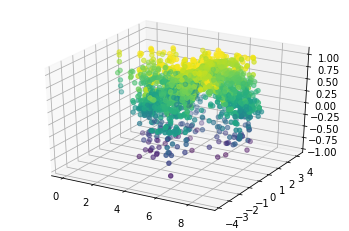

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(out_final['UMAP_x'], out_final['UMAP_y'], out_final['Average Growth'], c=out_final['Average Growth'], cmap='viridis')

plt.show()

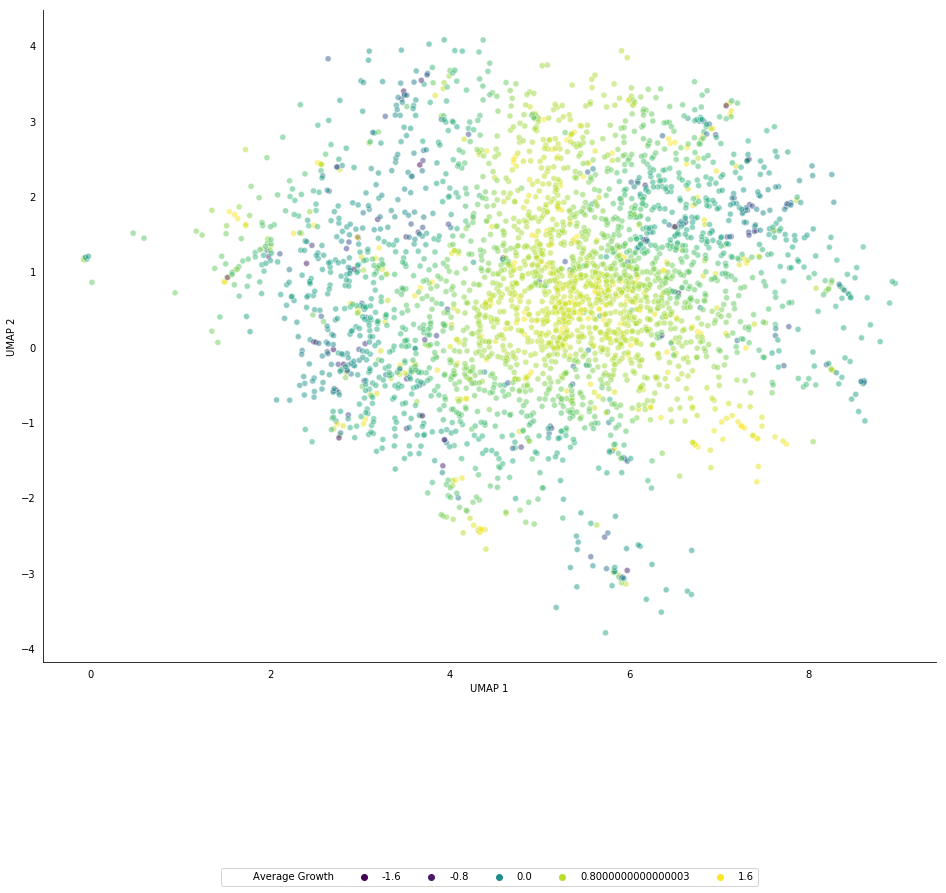

In [85]:
fig, ax = plt.subplots(figsize=(16,12))

#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=out_final['UMAP_x'], y=out_final['UMAP_y'], hue=out_final['Average Growth'], ax=ax, palette='viridis', vmax=1, vmin=-1, alpha=.5)


plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

#for i, row in plot_text.iterrows():
#    plt.annotate(row.name, (row[0], row[1]))
    
plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

In [107]:
t.columns

Index(['Drug', 'Cellline', 'Growth', 'Concentration', 'AAK1', 'ABL1', 'ABL2',
       'ACVR1', 'ACVR1B', 'ACVR2B',
       ...
       'TGFBR2', 'TNIK', 'TNK1', 'TNK2', 'TP53RK', 'TTK', 'TYK2', 'ULK1',
       'WEE1', 'YES1'],
      dtype='object', length=237)

In [159]:
louv_map = dict(louv.cluster_sub)
grps = [louv_map[x] for x in t.columns[4:]]
grp_perturbations = t.groupby(['Drug', 'Concentration']).agg(np.mean) # remove multiple cell lines
grp_perturbations = grp_perturbations.reset_index().iloc[:, 3:] * kin_standard_dev# slice to kinases
grp_perturbations = np.abs(grp_perturbations.values).T # transpose for a groupby
grp_perturbations = pd.DataFrame(grp_perturbations)
grp_perturbations['group'] = grps

# mean normalize to control for varying sizes
grp_perturbations = grp_perturbations.groupby('group').agg(np.mean).T

# anscombe transform
grp_perturbations = 2*np.sqrt(grp_perturbations + .375)

In [206]:
grp_perturbations -= np.min(grp_perturbations.values)

(array([650.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   4.]),
 array([0.        , 0.58163684, 1.16327368, 1.74491053, 2.32654737,
        2.90818421, 3.48982105, 4.07145789, 4.65309474, 5.23473158,
        5.81636842]),
 <a list of 10 Patch objects>)

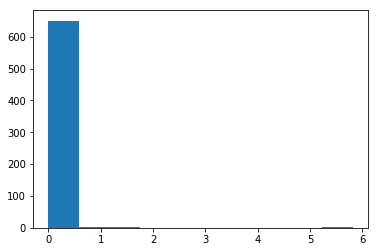

In [282]:
plt.hist(grp_perturbations.iloc[:, 15])

In [163]:
np.max(grp_perturbations.values)

7.04111329127158

/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empt

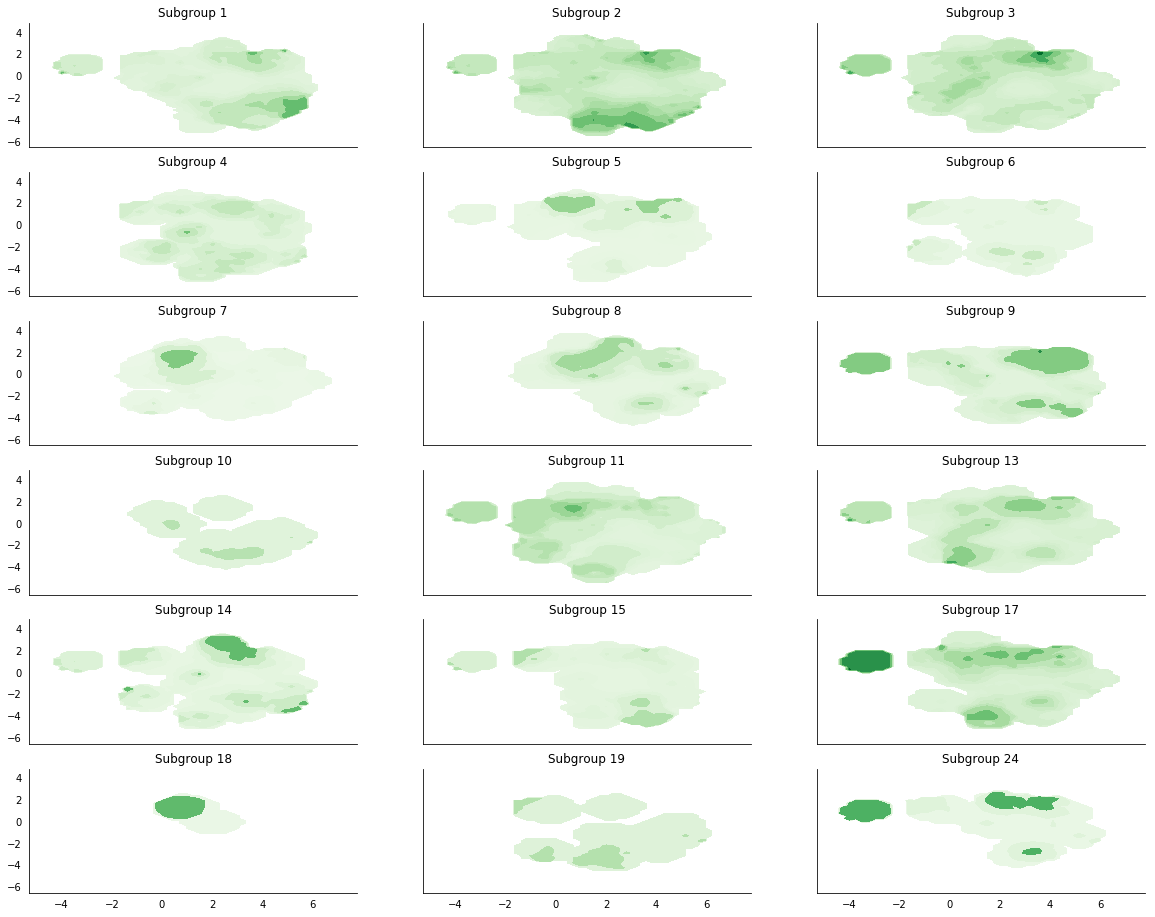

In [284]:
fig, axes = plt.subplots(figsize=(20,16), ncols=3, nrows=6, sharex=True, sharey=True)

for k in range(len(np.unique(grps))):
    #print(k, k//6, k%3)
    ax = axes[k//3, k%3]
    #cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    #sns.scatterplot(x=u_coords[:, 0].tolist(), y=u_coords[:, 1].tolist(), hue=grp_perturbations.iloc[:, k].values, ax=ax, palette='viridis', vmax=7, vmin=0, alpha=.0, legend=False)

    reg = RadiusNeighborsRegressor(weights='distance', n_jobs=2)
    reg.fit(u_coords, grp_perturbations.iloc[:, k].values)

    reg_preds = reg.predict(final_sample)

    #sns.scatterplot(x=final_sample[:, 0].tolist(), y=final_sample[:, 1].tolist(), hue=reg_preds, ax=ax, palette='viridis', vmax=7, vmin=0, alpha=0, legend=False)

    #levels=[0, .5, 1, 1.5, 2, 3, 5, 6]
    levels=list(np.unique(np.percentile(grp_perturbations.iloc[:, k], [0,15,30,45,55,65,75,80,85,90,95,99,100])))

    x_lims = (np.min(u_coords[:, 0])-2, np.max(u_coords[:, 0])+2)
    y_lims = (np.min(u_coords[:, 1])-2, np.max(u_coords[:, 1])+2)
    
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)

    def get_grid_input(lims):
        return np.arange(lims[0], lims[1], (lims[1] - lims[0])/50)

    # create a meshgrid to contour
    cntr_x, cntr_y = np.meshgrid(get_grid_input(x_lims), get_grid_input(y_lims))

    # fill the contours with model prediction
    cntr_z = reg.predict(np.array(list(zip(cntr_x.flatten(), cntr_y.flatten()))))
    cntr_z[np.isnan(cntr_z)] = -1
    cntr_z = cntr_z.reshape(cntr_x.shape)

    cntr = ax.contourf(cntr_x,cntr_y,cntr_z,levels,cmap='Greens', alpha = 1, vmin=-.5) 

    #plt.clabel(cntr,fmt='%f')

    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', right=False, left=False)

    for pos in ['right','top']:
        ax.spines[pos].set_visible(False)

    #plt.xlabel('UMAP 1')
    #plt.ylabel('UMAP 2')

    #for i, row in plot_text.iterrows():
    #    plt.annotate(row.name, (row[0], row[1]))

    #plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)
    
    ax.set_title('Subgroup ' + str(np.unique(grps)[k]))


plt.show()